# Una semplice rete neurale per approssimare numericamente funzioni reali

Luca Mari, marzo 2023

L'implementazione in `numpy` di una semplice rete neurale -- con un neurone di input, uno strato nascosto, e un neurone di output -- per approssimare funzioni $\mathbb{R} \rightarrow \mathbb{R}$, per esempio $sin(x)$ tra $-\pi$ e $\pi$.  
Una volta che sia stata addestrata, la rete dovrebbe calcolare il valore $f(x)$ corrispondente a ogni argomento $x$ dato in input.

Inizializziamo il contesto, la struttura e i parametri della rete.  
La rete ha dunque tre strati: L0 (1 neurone), L1 (`layer_size` neuroni), L2 (1 neurone),  
in cui:
* L0 riceve l'argomento $x$,
* L1 calcola una funzione $f_0$ che per il neurone $i$-esimo è $l_i = \sigma(w_{0,i} \cdot x)$, dove $w_{0,i}$ è l'$i$-esimo parametro tra L0 e L1, cioè il peso della $i$-esima connessione tra L0 e L1 e $\sigma$ è la funzione sigmoide,
* L2 calcola una funzione $f_1 = \sum_i w_{1,i} \cdot l_i$, dove $w_{1,i}$ è l'$i$-esimo parametro tra L1 e L2, cioè il peso della $i$-esima connessione tra L1 e L2.

Dunque complessivamente la rete calcola la funzione $F(x) = f_1(f_0(x)) = \sum_i w_{1,i} \cdot \sigma(w_{0,i} \cdot x)$.  
Una volta che $F$ sia stata calcolata su un training set di $n$ argomenti $x_j$, ogni elemento del campione di valori $F(x_j)$ così ottenuti può essere confrontato con il rispettivo risultato atteso $y_j$ e il risultato sintetizzato in termini di errore quadratico medio (_mean square error_, MSE), $\sum_j (F(x_j) - y_j)^2 / n$, che è la funzione $G$ che si vuole minimizzare rispetto ai parametri $w_{0,i}$ e $w_{1,i}$, dunque in quanto funzione $G(w_0, w_1)$.  
Si può con ciò applicare la _chain rule_, secondo cui la derivata di $g(f(x))$ è $g'(f(x)) \cdot f'(x)$, che in questo caso



in cui in questo caso $g'(f(x)) = 2 \cdot \sum_j (F(x_j) - y_j) / n$ e per il neurone $i$-esimo $f'(x) = \sigma'(w_{0,i} \cdot x)$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x:np.ndarray) -> np.ndarray: return 1 / (np.exp(-x) + 1)    
def d_sigmoid(x:np.ndarray) -> np.ndarray: return (np.exp(-x)) / ((np.exp(-x) + 1)**2)

layer_size = 100                # numero di neuroni dello strato nascosto

w0 = np.random.uniform(-1, 1, size=[1, layer_size])
w1 = np.random.uniform(-1, 1, size=[layer_size, 1])

Definiamo la funzione da approssimare, in questo caso $sin(x)$ con $-\pi \le x \le \pi$.

In [2]:
the_fun = lambda x: np.sin(x)   # la funzione da approssimare
the_min = -np.pi                # l'argomento minimo
the_max = np.pi                 # l'argomento massimo

Definiamo la funzione di addestramento:
* nel _forward pass_ gli elementi del training set sono applicati, in parallelo per ogni "epoca", alla rete, ottenendo un risultato,
* che viene confrontato con il valore corretto tramite il _mean square error_, di cui si calcola la derivata,
* che nel _backward pass_ viene propagata all'indietro nella rete per correggere i valori dei parametri. 

In [3]:
def train(w0:np.ndarray, w1:np.ndarray, epochs:int, trainingset_size:int, learning_rate:float, log:bool=False) -> tuple[np.ndarray,np.ndarray]:
    if log: print('Epoca\tMSE')

    for j in range(epochs):  
        # il training set
        x_train = np.random.uniform(the_min, the_max, size=[trainingset_size, 1])
        y_train = the_fun(x_train)

        # L0->L1: l1.shape: (dataset_size, layer_size): una riga per ogni datapoint e una colonna per ogni neurone di L1
        l1 = x_train.dot(w0)
        l1_sigmoid = sigmoid(l1)

        # L1->L2: l2.shape: (dataset_size, 1): una riga per ogni datapoint
        l2 = l1_sigmoid.dot(w1)

        if log and j % 500 == 0:
            mse = np.square(l2 - y_train).sum() / trainingset_size
            print(f'{j}\t{mse:.4f}')

        # derivata dell'MSE: d_mse.shape -> (dataset_size, 1)
        d_mse = 2 * (l2 - y_train) / trainingset_size

        # update_l2.shape: (layer_size, 1): la stessa di w1, i cui elementi sono da aggiornare
        update_l2 = l1_sigmoid.T @ d_mse

        # error.shape: (dataset_size, layer_size)
        error = (w1.dot(d_mse.T)).T * d_sigmoid(l1)

        # update_l1.shape: (1, layer_size): la stessa di w0, i cui elementi sono da aggiornare
        update_l1 = x_train.T @ error

        w0 -= learning_rate * update_l1
        w1 -= learning_rate * update_l2
    return w0, w1

Dopo aver inizializzato gli iperparametri relativi all'addestramento, la funzione di addestramento può essere ora eseguita:

In [4]:
epochs = 5000                   # numero di ripetizioni ("epoca") del processo di addestramento
trainingset_size = 1000         # numero di datapoint per ogni addestramento
learning_rate = 0.001

w0, w1 = train(w0, w1, epochs, trainingset_size, learning_rate, log=True)

Epoca	MSE
0	1.8208
500	0.1221
1000	0.1183
1500	0.1030
2000	0.0925
2500	0.0862
3000	0.0781
3500	0.0686
4000	0.0626
4500	0.0541


Ora che la rete è stata addestrata, la possiamo mettere alla prova:

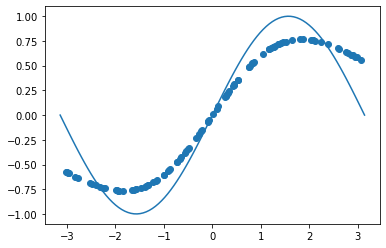

In [5]:
# il test set
testset_size = 100
x_test = np.random.uniform(the_min, the_max, size=[testset_size, 1])

# il forward pass
l1 = x_test.dot(w0)
l1_sigmoid = sigmoid(l1)
y_test = l1_sigmoid.dot(w1)

# la funzione da approssimare
x = np.linspace(the_min, the_max, 100)
y = the_fun(x)

plt.plot(x, y)
plt.scatter(x_test, y_test)
plt.show()